# Testing DoWhy's Limits

In [1]:
# Imports

import numpy as np
import pandas as pd
from dowhy import CausalModel
import dowhy.datasets

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Basic Confounder Example


![Basic Confouder Example](./testing_limits_figures/image-1.png)

### Discrete Variables

- Works as continuous

In [43]:
rvar = 1 if np.random.uniform() >0.5 else 0
data_dict = dowhy.datasets.xy_dataset(10000, effect=rvar,
                                      num_common_causes=1,
                                      sd_error=0.2)
df = pd.DataFrame(data_dict["df"]) 
df["Treatment"], df["Outcome"], df["w0"] = map(lambda x: dowhy.datasets.convert_continuous_to_discrete(x), [df["Treatment"], df["Outcome"], df["w0"]])
df = df.drop(["s"], axis=1)
display(df.head())

,Treatment,Outcome,w0
0,2,4,-3
1,9,18,3
2,3,5,-3
3,6,12,0
4,2,6,-2


#### Without latent variables

- Everything working as expected

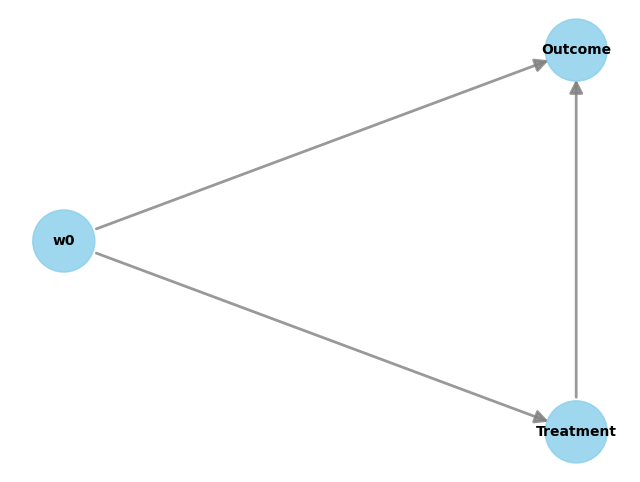

In [44]:
model= CausalModel(
        data=df,
        treatment=data_dict["treatment_name"],
        outcome=data_dict["outcome_name"],
        common_causes=data_dict["common_causes_names"],
        instruments=data_dict["instrument_names"])

model.view_model()

In [45]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                     
────────────(E[Outcome|w0])
d[Treatment]               
Estimand assumption 1, Unconfoundedness: If U→{Treatment} and U→Outcome then P(Outcome|Treatment,w0,U) = P(Outcome|Treatment,w0)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [46]:
# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")

# Step 4: Refute
res=model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter")
print(res)

Refute: Use a Placebo Treatment
Estimated effect:0.9882156107591902
New effect:0.0002528907098453459
p value:0.9199999999999999



In [47]:
# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(ref)

Refute: Add a random common cause
Estimated effect:0.9882156107591902
New effect:0.9882112893418173
p value:0.86



#### `w0` as an unobserved confounder

- In this scenario, no estimand was found.
- **Modeling Warning**: *"UserWarning: 1 variables are assumed unobserved because they are not in the dataset."*

In [53]:
# Step 1 - Model
model= CausalModel(
        data=df.drop(columns=["w0"]),
        treatment=data_dict["treatment_name"],
        outcome=data_dict["outcome_name"],
        common_causes=data_dict["common_causes_names"],
        instruments=data_dict["instrument_names"])

# model.view_model()

c:\Python310\lib\site-packages\dowhy\causal_model.py:582: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


In [54]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### Binary Variables

In [58]:
# Set seed for reproducibility
np.random.seed(42)

# Step 1: Generate random binary data
n_samples = 1000  # Number of samples

# Unobserved confounder U (binary)
U = np.random.binomial(1, 0.5, size=n_samples)

# Treatment X is influenced by U (binary)
X = np.random.binomial(1, 0.5 + 0.2 * (U - 0.5), size=n_samples)

# Outcome Y is influenced by both X and U (binary)
Y = np.random.binomial(1, 0.5 + 0.3 * (X - 0.5) + 0.2 * (U - 0.5), size=n_samples)

# Create a DataFrame
data = pd.DataFrame({'U': U, 'X': X, 'Y': Y})

data.head()

,U,X,Y
0,0,0,0
1,1,1,1
2,1,0,1
3,1,0,0
4,0,1,1


#### Without latent variables

- Everything working as expected

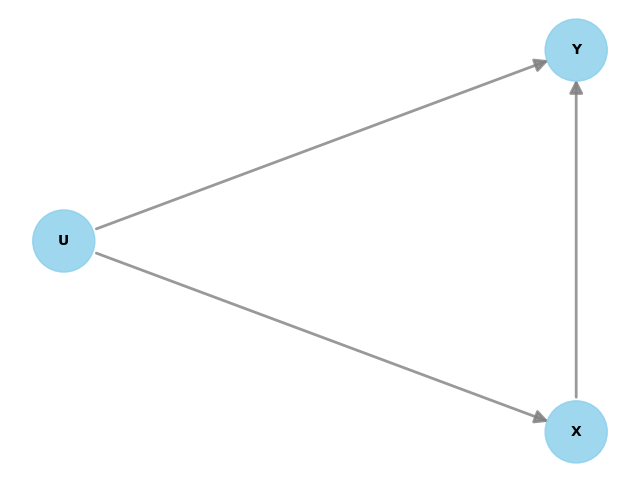

In [59]:
model= CausalModel(
        data=data,
        treatment="X",
        outcome="Y",
        common_causes=["U"])

model.view_model()

In [60]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d          
────(E[Y|U])
d[X]        
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,U,U) = P(Y|X,U)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [61]:
# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")

# Step 4: Refute
res=model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter")
print(res)

Refute: Use a Placebo Treatment
Estimated effect:0.3109002889784218
New effect:-0.002014799647248994
p value:1.0



In [62]:
# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")

# Step 4: Refute
res=model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter")
print(res)

Refute: Use a Placebo Treatment
Estimated effect:0.31094531026783145
New effect:-0.0023833402620209356
p value:0.84



#### `w0` as an unobserved confounder

- In this scenario, no estimand was found.
- **Modeling Warning**: *"UserWarning: 1 variables are assumed unobserved because they are not in the dataset."*

In [65]:
# Step 1 - Model
model= CausalModel(
        data=data.drop(columns=["U"]),
        treatment="X",
        outcome="Y",
        common_causes=["U"])

# model.view_model()

c:\Python310\lib\site-packages\dowhy\causal_model.py:582: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


In [66]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

